In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
from ipywidgets import HTML
from ipyevents import Event 
from IPython.display import display
import torch
import pickle
from util import renormalize, viz_util, patch_util
import numpy as np
torch.set_grad_enabled(False)

In [3]:
pretrained_path = 'pretrained/bird_pretrained_final.pkl'
# pretrained_path = 'pretrained/church_pretrained_final.pkl'
# pretrained_path = 'pretrained/ffhq6k_pretrained_final.pkl'
# pretrained_path = 'pretrained/mountain_pretrained_final.pkl'

with open(pretrained_path, 'rb') as f:
    G_base = pickle.load(f)['G_ema'].cuda()  # torch.nn.Module

# interactive generation

In [4]:
rng = np.random.RandomState(19)
z = torch.from_numpy(rng.standard_normal(G_base.z_dim)).float()
z = z[None].cuda()
c = None
ws = G_base.mapping(z, c, truncation_psi=0.5, truncation_cutoff=8)

Setting up PyTorch plugin "bias_act_plugin"... Done.


In [5]:
params = {
    'patch_size': G_base.img_resolution,
    'display_size': min(400, G_base.img_resolution),
    'shift_rate': 10,
    'zoom_rate': 10,
}

In [6]:
img = patch_util.scale_condition_wrapper(G_base, ws, transform=None, noise_mode='const', force_fp32=True)
bbox_info = viz_util.init_bbox(params)

# get initial transformation
base_img = img[0]
generated_img, display_img = viz_util.update_img(bbox_info, True, True, None, None, params, G_base, ws)
transform = viz_util.bbox_to_transformation(bbox_info)[None].to(ws.device)

img_url = renormalize.as_url(viz_util.draw_bbox(bbox_info, base_img), source='pil', size=params['display_size'])
patch_url = renormalize.as_url(display_img, size=params['display_size'])
img_html = '<div class="row"> <img src="%s"/> <img src="%s"/> </div>' % (img_url, patch_url)
l = HTML(img_html)

text = HTML('Use arrow keys to pan, i to zoom in, o to zoom out, and c to reset.')
h = HTML('Full size: %d' % bbox_info['full_size'])
d = Event(source=l, watched_events=['keydown'])

def handle_event(event):
    global bbox_info
    global display_img
    global generated_img
    bbox_info, generated_img, display_img = viz_util.update_bbox(
        event['key'], bbox_info, generated_img, display_img, G_base, ws, params)
    img_url =  renormalize.as_url(viz_util.draw_bbox(bbox_info, base_img), source='pil', size=params['display_size'])
    patch_url = renormalize.as_url(display_img, size=params['display_size'])
    img_html = '<div class="row"> <img src="%s"/> <img src="%s"/> </div>' % (img_url, patch_url)
    l.value = img_html
    content = 'Full size: %d' % bbox_info['full_size']
    h.value = content

d.on_dom_event(handle_event)
display(text, h, l)

Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.


HTML(value='Use arrow keys to pan, i to zoom in, o to zoom out, and c to reset.')

HTML(value='Full size: 276')

HTML(value='<div class="row"> <img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAQAAAAEACAIAAADTED8xAAEA…

# generate full image from patches

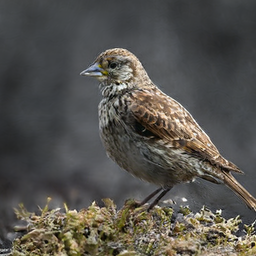

In [7]:
rng = np.random.RandomState(19)
z = torch.from_numpy(rng.standard_normal(G_base.z_dim)).float()
z = z[None].cuda()
c = None
ws = G_base.mapping(z, c, truncation_psi=0.5, truncation_cutoff=8)
img = patch_util.scale_condition_wrapper(G_base, ws, transform=None, noise_mode='const', force_fp32=True)
renormalize.as_image(img[0])

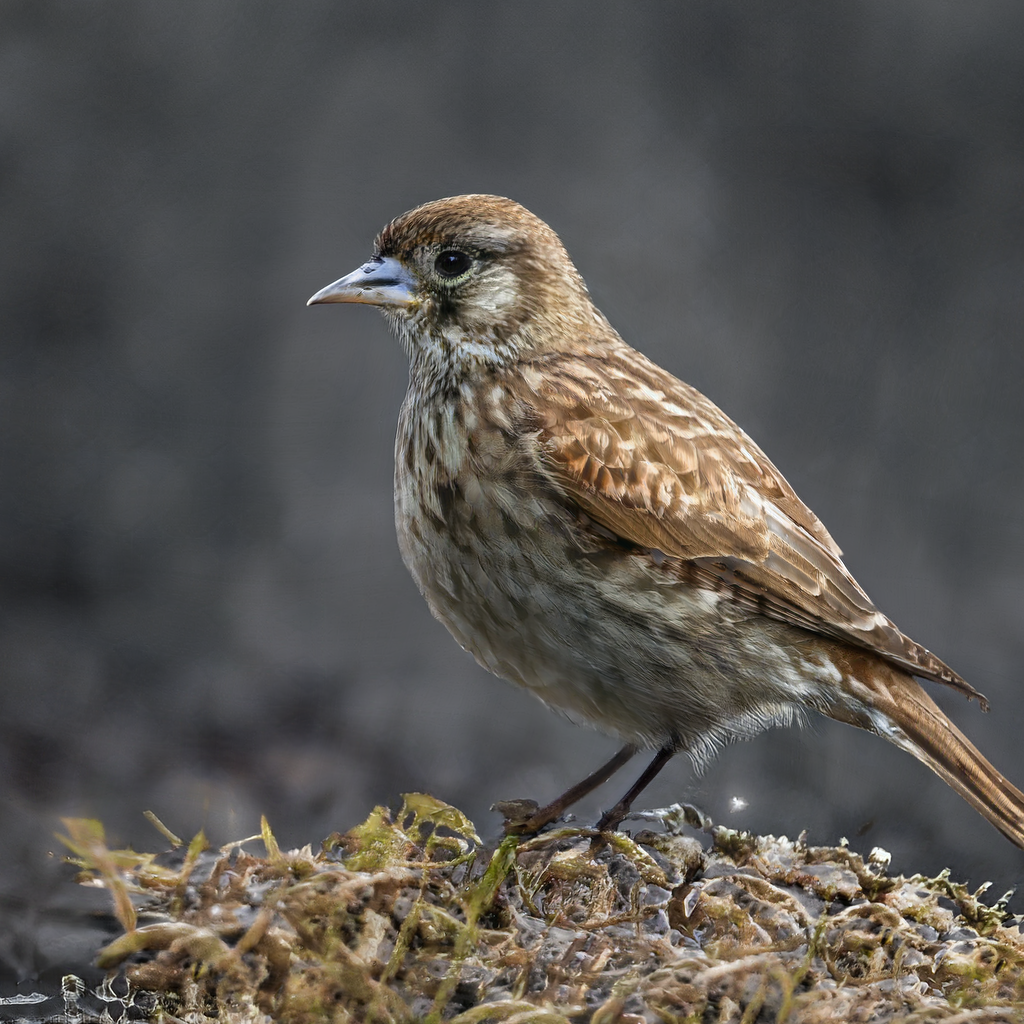

In [8]:
full_size = 1024
full = torch.zeros([1, 3, full_size, full_size])
patches = patch_util.generate_full_from_patches(full_size, G_base.img_resolution)
for bbox, transform in patches:
    img = patch_util.scale_condition_wrapper(G_base, ws, transform[None].cuda(), noise_mode='const', force_fp32=True)
    full[:, :, bbox[0]:bbox[1], bbox[2]:bbox[3]] = img
renormalize.as_image(full[0])

# panorama model

In [9]:
pretrained_path = 'pretrained/mountain_pano_pretrained_final.pkl'
with open(pretrained_path, 'rb') as f:
    G_pano = pickle.load(f)['G_ema'].cuda()  # torch.nn.Module

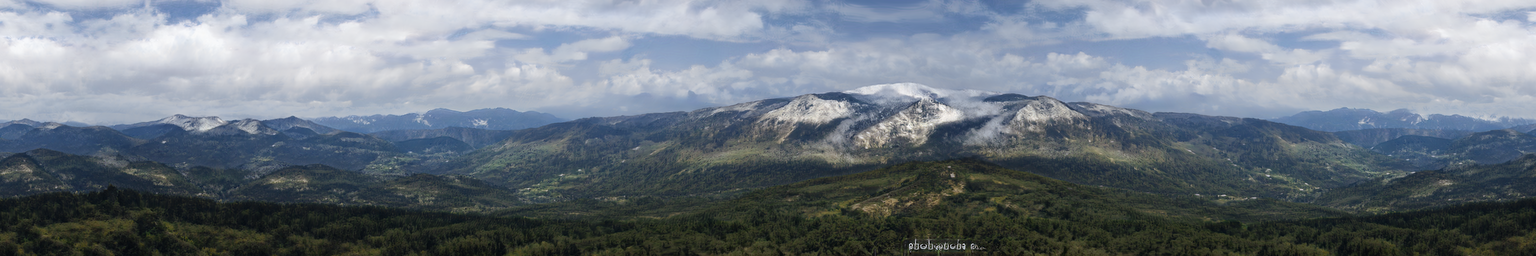

In [16]:
rng = np.random.RandomState(10)
z = torch.from_numpy(rng.standard_normal(G_pano.z_dim)).float()
z = z[None].cuda()
c = None

input_layer = G_pano.synthesis.input
grid = viz_util.make_grid(G_pano)
start_shift = np.random.randint(360 / input_layer.fov * input_layer.frame_size[0])
start_grid = grid[:, :, start_shift:start_shift+input_layer.size[0], :]
pano = viz_util.generate_pano_transform(G_pano, z, start_grid)
renormalize.as_image(pano)

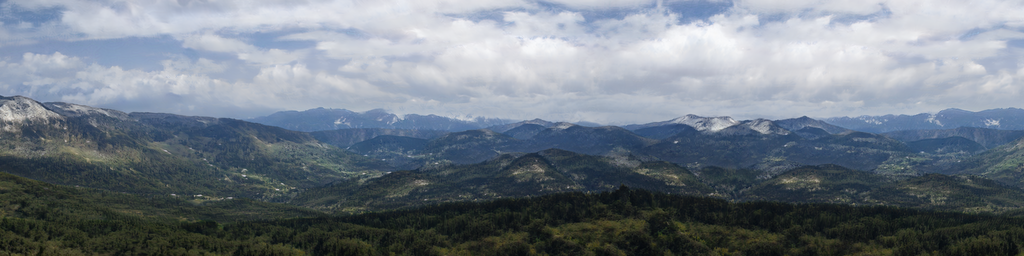

In [17]:
# splice the start and end of the pano together --> seamless image
pano_width = pano.shape[-1]
renormalize.as_image(torch.cat([pano, pano], dim=2)[:, :, pano_width-2*G_pano.img_resolution:pano_width+2*G_pano.img_resolution])